In [1]:
!pip install tensorflow
!pip install gym
!pip install keras
!pip install keras-rl2
!pip install matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.1/52.1 kB 3.2 MB/s eta 0:00:00


In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import gym

In [3]:
import warnings

warnings.filterwarnings('ignore')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
# Set up the CartPole environment
env = gym.make('CartPole-v1')
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
print(state_size, action_size)

4 2


In [5]:
env.observation_space

Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)

In [6]:
env.action_space

Discrete(2)

In [7]:
# Define the neural network model
def build_model():
    model = Sequential()
    model.add(Dense(24, input_dim=state_size, activation='relu'))
    model.add(Dense(24, activation='relu'))
    model.add(Dense(action_size, activation='linear'))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

In [8]:
# Define the replay buffer
class ReplayBuffer:
    def __init__(self, buffer_size):
        self.buffer_size = buffer_size
        self.buffer = []

    def add(self, experience):
        self.buffer.append(experience)
        if len(self.buffer) > self.buffer_size:
            self.buffer.pop(0)

    def sample(self, batch_size):
        indices = np.random.choice(len(self.buffer), batch_size, replace=False)
        return [self.buffer[i] for i in indices]

In [9]:
# Define the agent
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.model = build_model()
        self.target_model = build_model()
        self.target_model.set_weights(self.model.get_weights())
        self.buffer = ReplayBuffer(buffer_size=1000)
        self.gamma = 0.95     # size of observation space
        self.epsilon = 1.0    # method to balance exploration and exploitation
        self.epsilon_decay = 0.995
        self.epsilon_min = 0.01

    def select_action(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.choice(self.action_size)
        q_values = self.model.predict(state)
        return np.argmax(q_values[0])

    def train(self, batch_size):
        if len(self.buffer.buffer) < batch_size:
            return

        minibatch = self.buffer.sample(batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = self.model.predict(state)
            if done:
                target[0][action] = reward
            else:
                Q_future = max(self.target_model.predict(next_state)[0])
                target[0][action] = reward + self.gamma * Q_future
            self.model.fit(state, target, epochs=1, verbose=0)

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())

In [10]:
# Initialize the agent
agent = DQNAgent(state_size, action_size)

# Training parameters
episodes = 10
batch_size = 32

# Training loop
for episode in range(episodes):
    state = np.reshape(env.reset(), [1, state_size])

    total_reward = 0
    for time in range(1000):  # CartPole-v1 is considered solved if it runs for 500 steps
        action = agent.select_action(state)
        next_state, reward, done, _ = env.step(action)
        next_state = np.reshape(next_state, [1, state_size])

        agent.buffer.add((state, action, reward, next_state, done))
        state = next_state
        total_reward += reward

        if done:
          print("You won")
          break

    agent.train(batch_size)
    agent.update_target_model()

    if episode % 10 == 0:
        print(f"Episode: {episode}, Total Reward: {total_reward}")

# Save the trained model
agent.model.save('cartpole_model.keras')

You won
Episode: 0, Total Reward: 21.0
You won
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step

## Animation

1
[-0.02096673  0.15460716 -0.04787442 -0.35480568]
False
1
[-0.01787458  0.35037595 -0.05497053 -0.66219217]
False
0
[-0.01086706  0.1560602  -0.06821438 -0.38731197]
False
1
[-0.00774586  0.3520808  -0.07596061 -0.7006985 ]
False
1
[-7.0424221e-04  5.4816896e-01 -8.9974590e-02 -1.0162935e+00]
False
0
[ 0.01025914  0.35435438 -0.11030046 -0.7531645 ]
False
0
[ 0.01734623  0.1609121  -0.12536375 -0.497127  ]
False
1
[ 0.02056447  0.35755807 -0.13530628 -0.8265416 ]
False
0
[ 0.02771563  0.16452013 -0.15183713 -0.57929   ]
False
0
[ 0.03100603 -0.02818451 -0.16342291 -0.33802745]
False
1
[ 0.03044234  0.16883992 -0.17018346 -0.6774592 ]
False
0
[ 0.03381914 -0.02356023 -0.18373266 -0.44282094]
False
1
[ 0.03334793  0.17362127 -0.19258907 -0.7873289 ]
False
1
[ 0.03682036  0.37079316 -0.20833565 -1.1338905 ]
False
1
[ 0.04423622  0.5679407  -0.23101346 -1.4840258 ]
True


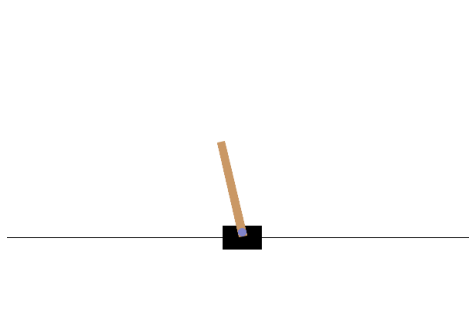

In [11]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import display, HTML

# Function to animate the CartPole environment
def animate_frames(frames):
    plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi=72)
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    ani = animation.FuncAnimation(plt.gcf(), animate, frames=len(frames), interval=50)
    display(HTML(ani.to_jshtml()))

# Function to test the trained agent and collect frames
def test_agent(agent, env):
    state = np.reshape(env.reset(), [1, state_size])
    frames = [env.render(mode='rgb_array')]

    for _ in range(500):  # CartPole-v1 is considered solved if it runs for 500 steps
        action = agent.select_action(state)
        print(action)
        next_state, _, done, _ = env.step(action)
        print(next_state)
        print(done)
        next_state = np.reshape(next_state, [1, state_size])
        frames.append(env.render(mode='rgb_array'))

        if done:
            break

    env.close()
    return frames

# Load the trained model
loaded_model = tf.keras.models.load_model('cartpole_model.keras')

# Test the trained agent and collect frames
test_env = gym.make('CartPole-v1')
#test_frames = test_agent(agent=DQNAgent(state_size, action_size), env=test_env)
agent.model = loaded_model
test_frames =test_agent(agent, env=test_env)

# Animate the frames
animate_frames(test_frames)